In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
from scipy import interpolate
import numpy_financial as npf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,3]
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
from datetime import datetime

import bond_utils

# Assignment 1: Yield Curves
### MAT1856: Mathematical Finance
<br>
Bilal Saleh Husain

## Bond Data

In [2]:
dates = ['06-01-2025', '07-01-2025', '08-01-2025', '09-01-2025', '10-01-2025', 
         '13-01-2025', '14-01-2025', '15-01-2025','16-01-2025', '17-01-2025']

B1 = bond_utils.Bond([99.73, 99.73, 99.74, 99.73, 99.74, 99.73, 99.73, 99.77, 99.78, 99.80], '01-03-2025', 1.25)
B2 = bond_utils.Bond([98.40, 98.41, 98.40, 98.42, 98.37, 98.36, 98.36, 98.40, 98.47, 98.50], '01-09-2025', 0.50)
B3 = bond_utils.Bond([96.99, 96.98, 96.97, 97.00, 96.90, 96.91, 96.80, 96.90, 97.01, 97.06], '01-03-2026', 0.25)
B4 = bond_utils.Bond([97.01, 96.99, 97.00, 97.03, 96.86, 96.77, 96.71, 96.85, 97.03, 97.07], '01-09-2026', 1.00)
B5 = bond_utils.Bond([96.62, 96.59, 96.58, 96.63, 96.39, 96.28, 96.19, 96.36, 96.60, 96.64], '01-03-2027', 1.25)
B6 = bond_utils.Bond([99.63, 99.56, 99.54, 99.58, 99.27, 99.13, 99.02, 99.20, 99.50, 99.53], '01-09-2027', 2.75)
B7 = bond_utils.Bond([101.82, 101.82, 101.70, 101.72, 101.52, 101.26, 101.02, 101.24, 101.58, 101.65], '01-03-2028', 3.50)
B8 = bond_utils.Bond([101.10, 101.14, 100.99, 100.94, 100.79, 100.49, 100.19, 100.42, 100.92, 101.02], '01-09-2028', 3.25)
B9 = bond_utils.Bond([104.07, 104.01, 103.90, 103.87, 103.53, 103.29, 102.99, 103.24, 103.80, 103.90], '01-03-2029', 4.00)
B10 = bond_utils.Bond([102.22, 102.14, 102.04, 101.98, 101.59, 101.28, 101.00, 101.27, 101.85, 101.97], '01-09-2029', 3.50)

# bonds are ordered from nearest maturity date to furthest
bonds = [B1, B2, B3, B4, B5, B6, B7, B8, B9, B10]

## Q4 

### $(a)$

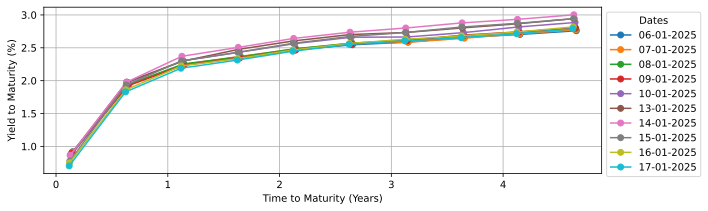

In [3]:
ytm_matrix = []

for i in range(len(dates)):
    ytm_values = []
    ttm_values = []
    
    for bond in bonds:
        ytm, T = bond_utils.compute_YTM(bond, i, current_date_str=dates[i])
        ytm_values.append(ytm)
        ttm_values.append(T)
        
    ytm_matrix.append(ytm_values)
    plt.plot(ttm_values, ytm_values, marker='o', label=dates[i])

ytm_matrix = np.array(ytm_matrix).T

plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Yield to Maturity (%)') 
plt.legend(title='Dates', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

### $(b)$

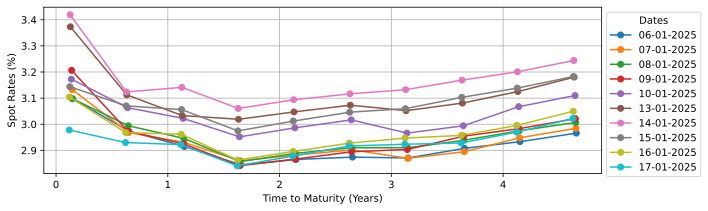

In [4]:
for i in range(len(dates)):
    spot_rates = bond_utils.compute_spot_curve(bonds, i, current_date_str=dates[i])
    plt.plot(list(spot_rates.keys()), list(spot_rates.values()), marker='o', label=dates[i])

plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Spot Rates (%)') 
plt.grid(True)
plt.legend()
plt.legend(title='Dates', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### $(c)$

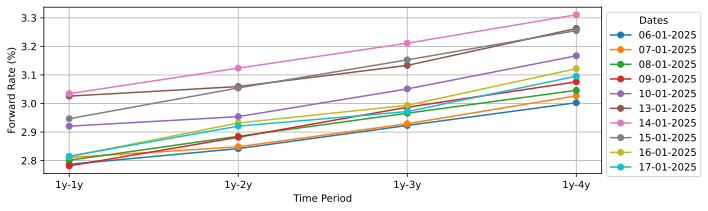

In [5]:
t=1
n_arr = [1,2,3,4]
forward_rate_matrix = []

for i in range(len(dates)):
    spot_rates = bond_utils.compute_spot_curve(bonds, i, current_date_str=dates[i])
    forward_rates = []
    
    for n in n_arr:
        forward_rates.append(bond_utils.compute_forward_rate(spot_rates, t, n) )

    forward_rate_matrix.append(forward_rates)
    plt.plot(['1y-1y', '1y-2y', '1y-3y', '1y-4y'], forward_rates, marker='o', label=dates[i])

forward_rate_matrix = np.array(forward_rate_matrix).T

plt.xlabel('Time Period')
plt.ylabel('Forward Rate (%)') 
plt.grid(True)
plt.legend(title='Dates', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## Q5

In [6]:
def log_return(r, r_next):
    return np.log(r_next/r)

### $(i)$ Covariance Matrix (Forward Rates)

In [18]:
X_fr = np.zeros((forward_rate_matrix.shape[0], forward_rate_matrix.shape[1]-1))

for var in range(X_fr.shape[0]):
    for day in range(X_fr.shape[1]):
        X_fr[var,day] = log_return( forward_rate_matrix[var,day] , forward_rate_matrix[var,day+1] )

In [19]:
cov_fr = np.cov(X_fr)

print('Covariance Matrix for Forward Rates:\n')
for i in cov_fr:
    print(i)

Covariance Matrix for Forward Rates:

[0.00084546 0.00062627 0.00061048 0.0006107 ]
[0.00062627 0.00057034 0.00058034 0.000524  ]
[0.00061048 0.00058034 0.00062708 0.0005524 ]
[0.0006107  0.000524   0.0005524  0.00051934]


### $(ii)$ Covariance Matrix (Yield)

In [20]:
X_ytm = np.zeros( (int(ytm_matrix.shape[0]/2), ytm_matrix.shape[1]-1) )

for var in range(X_ytm.shape[0]):
    for day in range(X_ytm.shape[1]):
        X_ytm[var,day] = log_return( ytm_matrix[2*var+1,day] , ytm_matrix[2*var+1,day+1] )
        if (X_ytm[var,day]==0): print(var,day)

In [21]:
cov_ytm = np.cov(X_ytm)

print('Covariance Matrix for Yield:\n')
for i in cov_ytm:
    print(i)

Covariance Matrix for Yield:

[0.00033476 0.00040828 0.00041338 0.00037342 0.00038678]
[0.00040828 0.00055696 0.00055154 0.00049016 0.00051099]
[0.00041338 0.00055154 0.00055421 0.0004801  0.00050777]
[0.00037342 0.00049016 0.0004801  0.00059967 0.00052544]
[0.00038678 0.00051099 0.00050777 0.00052544 0.00051005]


## Q6

### $(i)$ Covariance Matrix Eigenanalysis (Forward Rate)

In [16]:
fr_e_vals, fr_e_vecs = np.linalg.eig(cov_fr)

print('Eigenvalues (Forward Rate Covariance Matrix):\n')
for i, val in enumerate(fr_e_vals):
    print([val])

print()
print('Eigenvectors (Forward Rate Covariance Matrix):\n')
for j, vec in enumerate(fr_e_vecs):
    print(vec)

Eigenvalues (Forward Rate Covariance Matrix):

[0.0024071426767056977]
[0.00013040731756113117]
[4.672062592079188e-06]
[2.0006177487318772e-05]

Eigenvectors (Forward Rate Covariance Matrix):

[ 0.56386062  0.78229632  0.26418822 -0.01668085]
[ 0.47869472 -0.22764856 -0.39496465 -0.75035353]
[ 0.49195297 -0.5684424   0.64259953  0.14805859]
[ 0.45923287 -0.11428841 -0.60106019  0.64402638]


### $(ii)$ Covariance Matrix Eigenanalysis (Yield)

In [17]:
ytm_e_vals, ytm_e_vecs = np.linalg.eig(cov_ytm)

print('Eigenvalues (Yield Covariance Matrix):\n')
for i, val in enumerate(ytm_e_vals):
    print([val])

print()
print('Eigenvectors (Yield Covariance Matrix):\n')
for j, vec in enumerate(ytm_e_vecs):
    print(vec)

Eigenvalues (Yield Covariance Matrix):

[0.002392559235984831]
[0.00013207489865555932]
[2.4044877109899446e-05]
[4.581735407516158e-06]
[2.3915607439045496e-06]

Eigenvectors (Yield Covariance Matrix):

[-0.35886314 -0.24517218  0.87825746 -0.15886226  0.120559  ]
[-0.47292433 -0.34220115 -0.44270424 -0.50330148  0.45819377]
[-0.47057483 -0.4103028  -0.16955843  0.20052535 -0.73569727]
[-0.46447348  0.79233166  0.00561495 -0.31949024 -0.23317244]
[-0.45867586  0.16325174 -0.06241158  0.76102955  0.42415108]
